In [1]:
import networkx
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import *
from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv, ResGatedGraphConv, GATv2Conv, SAGEConv, GENConv, DeepGCNLayer, PairNorm, GINConv
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch.nn.functional as F
from imblearn.under_sampling import RandomUnderSampler
pd.options.mode.use_inf_as_na = True
from collections import Counter
from sklearn.feature_selection import SelectFromModel
import torch.nn as nn
import time
import pickle
from torch.nn import LayerNorm, Linear, ReLU
from torch_scatter import scatter
from tqdm import tqdm
from torch_geometric.loader import RandomNodeSampler
import math
import copy
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# np.random.seed(2022)
# torch.manual_seed(2022)

In [370]:
class Transition_layer(torch.nn.Module):
    def __init__(self, act, norm, lin):
        super().__init__()
        self.act = act
        self.norm = norm
        self.lin = lin
    def forward(self, x):
        x = self.norm(x)
        x = self.act(x)
        x = self.lin(x)
        return x
        
class DenseGAT(torch.nn.Module):
    def __init__(self, in_channels, num_class, num_layers=6, num_blocks=3, growth_rate=10, theta=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.blocks = num_blocks
        self.theta = theta
        self.growth_rate = growth_rate
        self.base_rate = growth_rate
        self.in_channels = in_channels
        self.out_channels = num_class
        self.linear_layers = torch.nn.ModuleList()
        self.transition_layers = torch.nn.ModuleList()
        self.block_layers = torch.nn.ModuleList()
        self.node_encoder = Linear(in_channels, growth_rate)
        self.linear_layers.append(self.node_encoder)
        
        for i in range(self.blocks):
            # block
            layers = torch.nn.ModuleList()
            # 2^(i - 1) * k0
            self.growth_rate = int(math.pow(2, i) * self.base_rate)
            print(self.growth_rate)
            for j in range(1, self.num_layers + 1):
                conv = GATv2Conv(in_channels + (j - 1) * self.growth_rate, self.growth_rate)
                norm = LayerNorm(self.growth_rate)
                act = ReLU()
                layer = DeepGCNLayer(conv, norm, act, block='dense')
                layers.append(layer)
            self.block_layers.append(layers)
            
            # transition
            hidden_channels = in_channels +  self.num_layers * self.growth_rate
            out_channels = int(hidden_channels * self.theta)
            transition_norm = LayerNorm(hidden_channels, elementwise_affine=True)
            transition_act = ReLU()
            transition_lin = Linear(hidden_channels, out_channels)
            transitionLayer = Transition_layer(transition_act, transition_norm, transition_lin)
            self.transition_layers.append(transitionLayer)
            in_channels = copy.copy(out_channels)
        
        self.lin_last = Linear(in_channels, self.out_channels)
        self.linear_layers.append(self.lin_last)
        
    def forward(self, x, edge_index):
#         x = self.linear_layers[0](x)
        for i in range(self.blocks):
            # block layer
            for layer in self.block_layers[i]:
                x = layer(x, edge_index)
            # transition layer
            x = self.transition_layers[i](x)
        x = self.linear_layers[-1](x)
        return x

In [312]:
def train():
    total_loss = total_correct = total_examples = 0
    start_time = time.time()
    for batch in train_loader:
        batch = batch.to(device)
        y = batch.y[:batch.batch_size]
        optimizer.zero_grad()
        y_hat = model(batch.x.to(device), batch.edge_index.to(device))[:batch.batch_size]
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * batch.batch_size
        total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
    end_time = time.time()  
    
    return total_loss / total_examples, total_correct / total_examples

def inferrence(model, subgraph_loader):
    total_loss = total_correct = total_examples = 0
    xs = []
    y = []
    pbar = tqdm(total=len(subgraph_loader))
    for batch in subgraph_loader:
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        xs.append(y_hat.cpu())
        y_true = batch.y[:batch.batch_size]
        y.append(y_true.cpu())
        pbar.update(1)
    pbar.close()
    y_hat = torch.cat(xs, 0)
    y_hat = y_hat.detach().numpy()
    y_hat = np.argmax(y_hat, -1)
    y = torch.cat(y, 0)
    print(y_hat)
    print(y)
    cr1 = classification_report(y, y_hat,digits=4)
    cf = confusion_matrix(y, y_hat)
    print(cr1)
    print(cf)


In [347]:
train_data = torch.load(r'/home/xiaoyujie/densegat/tonlot/NF_UNSW15_train_data')

In [348]:
test_data = torch.load(r'/home/xiaoyujie/densegat/tonlot/NF_UNSW15_test_data')

In [349]:
train_data,test_data

(Data(x=[1673192, 39], edge_index=[2, 38668506], y=[1673192], num_nodes=1673192),
 Data(x=[717083, 39], edge_index=[2, 7075088], y=[717083], num_nodes=717083))

In [350]:
Counter(train_data.y.numpy()),Counter(test_data.y.numpy())

(Counter({0: 1606655,
          4: 15617,
          1: 8945,
          5: 11592,
          3: 1518,
          2: 22086,
          9: 115,
          8: 999,
          6: 4056,
          7: 1609}),
 Counter({0: 688567,
          2: 9465,
          5: 4968,
          7: 690,
          1: 3834,
          6: 1738,
          4: 6693,
          3: 651,
          8: 428,
          9: 49}))

In [351]:
test_data

Data(x=[717083, 39], edge_index=[2, 7075088], y=[717083], num_nodes=717083)

In [342]:
# train_data.edge_index = torch.LongTensor(train_data.edge_index.numpy())
# test_data.edge_index = torch.LongTensor(test_data.edge_index.numpy())

In [343]:
# 二分类试试

In [344]:
train_label = train_data.y.numpy()
test_label = test_data.y.numpy()

In [345]:
train_label[train_label != 0] = 1
test_label[test_label != 0] = 1

In [346]:
train_data.y = torch.LongTensor(train_label)
test_data.y = torch.LongTensor(test_label)

In [175]:
Counter(train_data.y.numpy())

Counter({0: 1606655, 1: 66537})

In [176]:
Counter(test_data.y.numpy())

Counter({0: 688567, 1: 28516})

In [352]:
# 开始

In [353]:
train_num_nodes = torch.arange(len(train_data.y))
test_num_nodes = torch.arange(len(test_data.y))

In [372]:
train_data = train_data.to('cpu')
test_data = test_data.to('cpu')
hop = [50]*20
train_loader = NeighborLoader(train_data, input_nodes = train_num_nodes, num_neighbors=hop, batch_size=1024, shuffle=True)

In [373]:
next(iter(train_loader))

Data(x=[1876, 39], edge_index=[2, 872], y=[1876], num_nodes=1876, batch_size=1024)

In [360]:
subgraph_loader = NeighborLoader(test_data, input_nodes=test_num_nodes,num_neighbors=hop, batch_size=1024, shuffle=False)

In [374]:
in_channels = train_data.x.size(-1)
num_class = 10
model = DenseGAT(in_channels=in_channels, num_class=num_class, 
                 num_layers=10, num_blocks=1, growth_rate=10, theta=0.5)
loss_all = []

10


In [375]:
model

DenseGAT(
  (linear_layers): ModuleList(
    (0): Linear(in_features=39, out_features=10, bias=True)
    (1): Linear(in_features=69, out_features=10, bias=True)
  )
  (transition_layers): ModuleList(
    (0): Transition_layer(
      (act): ReLU()
      (norm): LayerNorm((139,), eps=1e-05, elementwise_affine=True)
      (lin): Linear(in_features=139, out_features=69, bias=True)
    )
  )
  (block_layers): ModuleList(
    (0): ModuleList(
      (0): DeepGCNLayer(block=dense)
      (1): DeepGCNLayer(block=dense)
      (2): DeepGCNLayer(block=dense)
      (3): DeepGCNLayer(block=dense)
      (4): DeepGCNLayer(block=dense)
      (5): DeepGCNLayer(block=dense)
      (6): DeepGCNLayer(block=dense)
      (7): DeepGCNLayer(block=dense)
      (8): DeepGCNLayer(block=dense)
      (9): DeepGCNLayer(block=dense)
    )
  )
  (node_encoder): Linear(in_features=39, out_features=10, bias=True)
  (lin_last): Linear(in_features=69, out_features=10, bias=True)
)

In [376]:
sum(p.numel() for p in model.parameters())

28438

In [377]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [378]:
# 193.2389s

In [379]:
device = 'cuda:0'
model = model.to(device)
model.train()
flag = True
epochs = 500
for i in range(1, 1 + epochs):
    if i > 50 and flag:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        flag = False
    start_time = time.time()
    train_loader = NeighborLoader(train_data, input_nodes = train_num_nodes, num_neighbors=hop, batch_size=1024, shuffle=True)
    loss, acc = train()
    end_time = time.time()
    print('epoch: {:04d}'.format(i),
          'loss_train: {:.4f}'.format(loss),
          'acc_train: {:.4f}'.format(acc),
          'time: {:.4f}s'.format(end_time - start_time))
    loss_all.append(loss)

epoch: 0001 loss_train: 0.0633 acc_train: 0.9796 time: 79.2730s
epoch: 0002 loss_train: 0.0417 acc_train: 0.9850 time: 79.2398s
epoch: 0003 loss_train: 0.0395 acc_train: 0.9858 time: 73.8025s
epoch: 0004 loss_train: 0.0386 acc_train: 0.9861 time: 68.6639s
epoch: 0005 loss_train: 0.0378 acc_train: 0.9863 time: 64.8540s
epoch: 0006 loss_train: 0.0370 acc_train: 0.9866 time: 50.2064s
epoch: 0007 loss_train: 0.0365 acc_train: 0.9867 time: 53.6126s
epoch: 0008 loss_train: 0.0361 acc_train: 0.9869 time: 59.6187s
epoch: 0009 loss_train: 0.0357 acc_train: 0.9870 time: 54.5260s
epoch: 0010 loss_train: 0.0353 acc_train: 0.9871 time: 51.4456s
epoch: 0011 loss_train: 0.0352 acc_train: 0.9872 time: 61.3119s
epoch: 0012 loss_train: 0.0348 acc_train: 0.9872 time: 53.4032s
epoch: 0013 loss_train: 0.0345 acc_train: 0.9874 time: 59.9031s
epoch: 0014 loss_train: 0.0344 acc_train: 0.9873 time: 60.0890s
epoch: 0015 loss_train: 0.0341 acc_train: 0.9875 time: 61.7395s
epoch: 0016 loss_train: 0.0339 acc_train

KeyboardInterrupt: 

In [32]:
torch.save(model.state_dict(), 'unsw_model')

In [47]:
weight = torch.load('unsw_model', map_location='cpu')

In [ ]:
model.load_state_dict(weight)

In [380]:
def get_metrics(y_true, y_pred):
    cr = classification_report(y_true, y_pred, output_dict=True)
    df = pd.DataFrame(cr).transpose()
    cm = confusion_matrix(y_true, y_pred)
    print(df)
    print(cm)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    

In [381]:
device = 'cpu'
model = model.to(device)

In [382]:
y_hat = model(test_data.x.to(device), test_data.edge_index.to(device))
y_hat = y_hat.detach().numpy()

In [383]:
y_hat = np.argmax(y_hat, -1)
test_y = test_data.y.numpy()

In [ ]:
auc = roc_auc_score(test_y, y_hat, multi_class='ovo')
auc

/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

              precision    recall  f1-score        support
0              0.996556  0.998204  0.997379  688567.000000
1              0.904232  0.763432  0.827889    3834.000000
2              0.764511  0.830745  0.796253    9465.000000
3              0.164778  0.290323  0.210234     651.000000
4              0.777077  0.828627  0.802025    6693.000000
5              0.931632  0.822866  0.873878    4968.000000
6              0.416370  0.201956  0.271988    1738.000000
7              0.000000  0.000000  0.000000     690.000000
8              0.567308  0.413551  0.478378     428.000000
9              0.689655  0.408163  0.512821      49.000000
accuracy       0.988018  0.988018  0.988018       0.988018
macro avg      0.621212  0.555787  0.577084  717083.000000
weighted avg   0.987104  0.988018  0.987364  717083.000000
[[687330      2    394      1    790     17     27      0      6      0]
 [   232   2927    407    158     38      8     43      0     21      0]
 [   583    184   7863    16

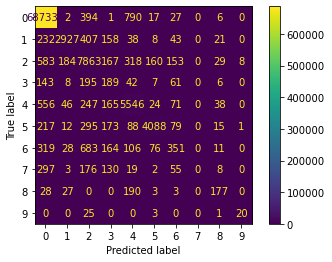

In [384]:
get_metrics(test_y, y_hat)

/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

              precision    recall  f1-score        support
0              0.991702  0.995227  0.993461  665630.000000
1              0.623030  0.716125  0.666342   13358.000000
2              0.755562  0.655624  0.702054    4196.000000
3              0.290300  0.256217  0.272196    4906.000000
4              0.992201  0.980060  0.986093   64644.000000
5              0.448276  0.286976  0.349933     453.000000
6              0.457823  0.375309  0.412480    7274.000000
7              0.000000  0.000000  0.000000      52.000000
8              0.130742  0.105866  0.116996     699.000000
9              0.181818  0.004981  0.009697     803.000000
accuracy       0.974154  0.974154  0.974154       0.974154
macro avg      0.487145  0.437639  0.450925  762015.000000
weighted avg   0.972335  0.974154  0.973017  762015.000000
[[662453    397     86    489     61     20   2124      0      0      0]
 [   764   9566    437   1600    285     59    488      0    156      3]
 [   512    580   2751    23

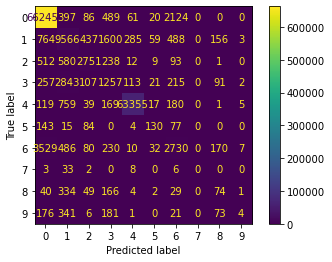

In [327]:
get_metrics(test_y, y_hat)

In [157]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.993463  0.998116  0.995784  688567.000000
1              0.864009  0.768910  0.813690    3834.000000
2              0.823272  0.815531  0.819383    9465.000000
3              0.231818  0.078341  0.117107     651.000000
4              0.789594  0.823099  0.805999    6693.000000
5              0.939882  0.799316  0.863918    4968.000000
6              0.399160  0.163982  0.232463    1738.000000
7              0.666667  0.002899  0.005772     690.000000
8              0.578462  0.439252  0.499336     428.000000
9              0.717949  0.571429  0.636364      49.000000
accuracy       0.987293  0.987293  0.987293       0.987293
macro avg      0.700428  0.546087  0.578982  717083.000000
weighted avg   0.985538  0.987293  0.985876  717083.000000
[[687270      4    379      1    811     16     79      1      6      0]
 [   468   2948    306     32     23      6     40      0     11      0]
 [   940    205   7719     2

In [149]:
get_metrics(test_y, y_hat)

/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

              precision    recall  f1-score        support
0              0.997366  0.997543  0.997454  688567.000000
1              0.472045  0.924883  0.625066    3834.000000
2              0.834024  0.701849  0.762249    9465.000000
3              0.000000  0.000000  0.000000     651.000000
4              0.642975  0.817720  0.719895    6693.000000
5              0.918298  0.764694  0.834487    4968.000000
6              0.312500  0.017261  0.032715    1738.000000
7              0.000000  0.000000  0.000000     690.000000
8              0.619048  0.242991  0.348993     428.000000
9              1.000000  0.061224  0.115385      49.000000
accuracy       0.985204  0.985204  0.985204       0.985204
macro avg      0.579626  0.452816  0.443624  717083.000000
weighted avg   0.984795  0.985204  0.983988  717083.000000
[[686875     59    350      0   1249     17     14      0      3      0]
 [   103   3546    149      0     28      4      4      0      0      0]
 [   657   1007   6643      

In [134]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.997213  0.996947  0.997080  300000.000000
1              0.893645  0.718832  0.796762    3834.000000
2              0.630130  0.882515  0.735267    9465.000000
3              0.600000  0.009217  0.018154     651.000000
4              0.756468  0.834454  0.793549    6693.000000
5              0.949678  0.771135  0.851144    4968.000000
6              0.235294  0.082854  0.122553    1738.000000
7              0.000000  0.000000  0.000000     690.000000
8              0.582090  0.273364  0.372019     428.000000
9              0.625000  0.102041  0.175439      49.000000
accuracy       0.973715  0.973715  0.973715       0.973715
macro avg      0.626952  0.467136  0.486197  328516.000000
weighted avg   0.972295  0.973715  0.971247  328516.000000
[[299084      9    291      0    600     13      2      1      0      0]
 [    18   2756    943      0     29      5     76      4      3      0]
 [   296     75   8353      

In [100]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.998497  0.996327  0.997411  150000.000000
1              0.720443  0.797861  0.757178    3834.000000
2              0.716841  0.859377  0.781664    9465.000000
3              0.647727  0.087558  0.154263     651.000000
4              0.834245  0.866278  0.849960    6693.000000
5              0.925586  0.811192  0.864621    4968.000000
6              0.287828  0.246260  0.265426    1738.000000
7              0.666667  0.002899  0.005772     690.000000
8              0.581325  0.450935  0.507895     428.000000
9              0.628571  0.448980  0.523810      49.000000
accuracy       0.958861  0.958861  0.958861       0.958861
macro avg      0.700773  0.556766  0.570800  178516.000000
weighted avg   0.958822  0.958861  0.956251  178516.000000
[[149449     11    235      1    275     16      9      1      3      0]
 [    11   3059    549      0     13     13    159      0     30      0]
 [    76    350   8134      

In [93]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score        support
0              0.974884  0.996273  0.985463  150000.000000
1              0.897554  0.765519  0.826295    3834.000000
2              0.795970  0.830534  0.812885    9465.000000
3              0.364486  0.059908  0.102902     651.000000
4              0.817106  0.866428  0.841044    6693.000000
5              0.962491  0.774758  0.858481    4968.000000
6              0.445672  0.139241  0.212188    1738.000000
7              0.136364  0.004348  0.008427     690.000000
8              0.575251  0.401869  0.473177     428.000000
9              0.583333  0.142857  0.229508      49.000000
accuracy       0.954245  0.954245  0.954245       0.954245
macro avg      0.655311  0.498173  0.535037  178516.000000
weighted avg   0.945792  0.954245  0.947987  178516.000000
[[149441      1    151     31    319      6     48      1      1      1]
 [   480   2935    337      1     17      6     30      0     28      0]
 [   711    201   7861      

In [88]:
get_metrics(test_y, y_hat)

/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

              precision    recall  f1-score        support
0              0.981875  0.995333  0.988558  150000.000000
1              0.743054  0.704486  0.723256    3834.000000
2              0.743124  0.850608  0.793241    9465.000000
3              0.000000  0.000000  0.000000     651.000000
4              0.739091  0.855371  0.792991    6693.000000
5              0.941133  0.762681  0.842562    4968.000000
6              0.395349  0.009781  0.019090    1738.000000
7              0.000000  0.000000  0.000000     690.000000
8              0.641618  0.259346  0.369384     428.000000
9              0.000000  0.000000  0.000000      49.000000
accuracy       0.950581  0.950581  0.950581       0.950581
macro avg      0.518524  0.443761  0.452908  178516.000000
weighted avg   0.939679  0.950581  0.942489  178516.000000
[[149300      1    313      0    381      4      1      0      0      0]
 [   366   2701    652      1    104      7      3      0      0      0]
 [   492    147   8051      

In [69]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.993643  0.995200  0.994421  30000.000000
1              0.861059  0.475222  0.612437   3834.000000
2              0.728238  0.883888  0.798549   9465.000000
3              0.394161  0.082949  0.137056    651.000000
4              0.849767  0.873002  0.861228   6693.000000
5              0.668146  0.848631  0.747650   4968.000000
6              0.401163  0.198504  0.265589   1738.000000
7              0.170659  0.082609  0.111328    690.000000
8              0.668790  0.490654  0.566038    428.000000
9              0.764706  0.530612  0.626506     49.000000
accuracy       0.868053  0.868053  0.868053      0.868053
macro avg      0.650033  0.546127  0.572080  58516.000000
weighted avg   0.861397  0.868053  0.856485  58516.000000
[[29856     2    49     1    58     2    26     6     0     0]
 [   30  1822   522     7    74  1258    59    37    25     0]
 [   23   191  8366    17   316   280   181    59    24     8]

In [31]:
get_metrics(test_y, y_hat)

              precision    recall  f1-score       support
0              0.989006  0.995533  0.992259  30000.000000
1              0.906751  0.781168  0.839288   3834.000000
2              0.697924  0.887797  0.781493   9465.000000
3              0.298507  0.092166  0.140845    651.000000
4              0.878060  0.868221  0.873112   6693.000000
5              0.859992  0.833333  0.846453   4968.000000
6              0.428571  0.177791  0.251322   1738.000000
7              0.142857  0.040580  0.063205    690.000000
8              0.624679  0.567757  0.594859    428.000000
9              0.722222  0.530612  0.611765     49.000000
accuracy       0.886612  0.886612  0.886612      0.886612
macro avg      0.654857  0.577496  0.599460  58516.000000
weighted avg   0.875697  0.886612  0.876479  58516.000000
[[29866     1    53     0    62     1    15     1     1     0]
 [   52  2995   572    18    27    81    40    24    25     0]
 [   48   222  8403    21   320   235   136    36    34    10]

In [22]:
all_data = torch.load(r'/home/xiaoyujie/densegat/mydata/unswnb15_directed_lg_data_2')

In [49]:
all_data_label = all_data.y.numpy()

In [109]:
all_data_label[all_data_label != 0] = 1
all_data.y = torch.LongTensor(all_data_label)

In [24]:
all_data

Data(x=[421283, 41], edge_index=[2, 49827], y=[421283], num_nodes=421283, train_mask=[358090], test_mask=[63193])

In [59]:
subgraph_loader = NeighborLoader(all_data, input_nodes=all_data.test_mask,
                                 num_neighbors=hop, batch_size=1024, shuffle=False)

In [16]:
device = 'cpu'

In [52]:
train_data = train_data.to(device)
test_data = test_data.to(device)

In [53]:
Counter(test_data.y.numpy())

Counter({2: 2098,
         1: 6679,
         4: 32322,
         3: 2453,
         7: 26,
         6: 3637,
         0: 15000,
         8: 349,
         5: 227,
         9: 402})

In [54]:
Counter(all_data.y[all_data.test_mask].numpy())

Counter({2: 2098,
         1: 6679,
         4: 32322,
         3: 2453,
         7: 26,
         6: 3637,
         0: 15000,
         8: 349,
         5: 227,
         9: 402})

In [17]:
model = model.to(device)

In [60]:
all_data = all_data.to(device)

In [61]:
inferrence(model, subgraph_loader)

100%|██████████| 62/62 [00:03<00:00, 16.13it/s]


[2 1 1 ... 6 1 4]
tensor([2, 1, 1,  ..., 6, 3, 4])
              precision    recall  f1-score   support

           0     0.9973    0.9883    0.9928     15000
           1     0.6075    0.8560    0.7106      6679
           2     0.8806    0.7526    0.8116      2098
           3     0.3515    0.1553    0.2154      2453
           4     0.9938    0.9843    0.9891     32322
           5     0.5766    0.5639    0.5702       227
           6     0.8412    0.8447    0.8429      3637
           7     0.1579    0.1154    0.1333        26
           8     0.5946    0.0630    0.1140       349
           9     0.5816    0.1418    0.2280       402

    accuracy                         0.9115     63193
   macro avg     0.6583    0.5465    0.5608     63193
weighted avg     0.9097    0.9115    0.9047     63193

[[14824    15     3     3     1     2   141     0     0    11]
 [   12  5717   134   429   114    32   202    14     4    21]
 [    0   411  1579    72     1     7    26     0     2     0]
 

In [57]:
inferrence(model, subgraph_loader)

100%|██████████| 62/62 [00:09<00:00,  6.32it/s]


[5 1 1 ... 6 3 4]
tensor([2, 1, 1,  ..., 6, 3, 4])
              precision    recall  f1-score   support

           0     0.9966    0.9875    0.9921     15000
           1     0.5970    0.8266    0.6933      6679
           2     0.8023    0.4256    0.5562      2098
           3     0.3226    0.1916    0.2404      2453
           4     0.9924    0.9841    0.9882     32322
           5     0.1806    0.6300    0.2807       227
           6     0.8237    0.8001    0.8117      3637
           7     0.1905    0.1538    0.1702        26
           8     0.5385    0.0602    0.1082       349
           9     0.6164    0.1119    0.1895       402

    accuracy                         0.8961     63193
   macro avg     0.6060    0.5172    0.5031     63193
weighted avg     0.9014    0.8961    0.8916     63193

[[14813    27     1     4     1     4   141     0     0     9]
 [   12  5521   160   579   142    39   193    16     5    12]
 [    6   430   893   104    17   520   126     0     2     0]
 

In [118]:
inferrence(model, subgraph_loader)

100%|██████████| 31/31 [00:01<00:00, 16.88it/s]


[1 0 0 ... 1 1 1]
tensor([1, 0, 0,  ..., 1, 1, 1])
              precision    recall  f1-score   support

           0     0.9995    0.9840    0.9917      7500
           1     0.9949    0.9998    0.9974     23371

    accuracy                         0.9960     30871
   macro avg     0.9972    0.9919    0.9945     30871
weighted avg     0.9960    0.9960    0.9960     30871

[[ 7380   120]
 [    4 23367]]


In [42]:
inferrence(model, test_data, subgraph_loader)

100%|██████████| 18/18 [00:00<00:00, 33.60it/s]

[ 0  7  0 ...  0 10  6]
tensor([ 0,  8,  0,  ...,  0, 10,  6])
              precision    recall  f1-score   support

           0     0.8783    0.9380    0.9071      4030
           1     0.9895    0.9842    0.9868      2020
           2     0.9661    0.9627    0.9644      2011
           3     0.9796    0.9529    0.9660       403
           4     1.0000    0.2500    0.4000         8
           5     0.9557    0.9702    0.9629      1645
           6     0.8966    0.9138    0.9051      1148
           7     0.9144    0.9017    0.9080      1149
           8     0.9676    0.8519    0.9061      1155
           9     0.9708    0.9239    0.9467      1905
          10     0.9908    0.9710    0.9808      1997

    accuracy                         0.9418     17471
   macro avg     0.9554    0.8746    0.8940     17471
weighted avg     0.9433    0.9418    0.9419     17471

[[3780    2   63    7    0   46  106    1    1   21    3]
 [  10 1988    0    0    0    0    0    0    0   22    0]
 [  68  

In [204]:
train_data = train_data.to('cpu')
test_data = test_data.to('cpu')

In [205]:
x_train = train_data.x.numpy()
y_train = train_data.y.numpy()

In [206]:
x_test = test_data.x.numpy()
y_test = test_data.y.numpy()

In [207]:
from catboost import CatBoostClassifier

In [208]:
from lightgbm import LGBMClassifier

In [209]:
from sklearn.ensemble._forest import RandomForestClassifier

In [210]:
from sklearn.ensemble import AdaBoostClassifier

In [211]:
from sklearn.neural_network import MLPClassifier

In [215]:
cbc = MLPClassifier(verbose=True, tol=1e-6, batch_size=1024, hidden_layer_sizes=(30,15, 2), 
                    max_iter=500, learning_rate_init= 0.01, solver='adam', learning_rate='adaptive', alpha = 0.002)

In [170]:
cbc = AdaBoostClassifier()

In [216]:
cbc.fit(x_train, y_train)

Iteration 1, loss = 0.03823301
Iteration 2, loss = 0.01401812
Iteration 3, loss = 0.01253359


/home/xiaoyujie/anaconda3/envs/densegat2/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(alpha=0.002, batch_size=1024, hidden_layer_sizes=(30, 15, 2),
              learning_rate='adaptive', learning_rate_init=0.01, max_iter=500,
              tol=1e-06, verbose=True)

In [217]:
y_pred = cbc.predict(x_test)

In [218]:
df = classification_report(y_test, y_pred, digits=4, output_dict=True)
df = pd.DataFrame(df).transpose()

In [219]:
df

,precision,recall,f1-score,support
0,0.999064,0.996696,0.997879,688567.000000
1,0.924539,0.977451,0.950259,28516.000000
accuracy,0.995931,0.995931,0.995931,0.995931
macro avg,0.961801,0.987074,0.974069,717083.000000
weighted avg,0.996100,0.995931,0.995985,717083.000000


In [220]:
roc_auc_score(y_test, y_pred)

0.9870736461386379

In [163]:
df

,precision,recall,f1-score,support
0,0.710533,0.993633,0.828569,30000.00000
1,0.270869,0.041471,0.071929,3834.00000
2,0.513353,0.574749,0.542319,9465.00000
3,0.006981,0.006144,0.006536,651.00000
4,0.446337,0.039145,0.071978,6693.00000
5,0.042105,0.001610,0.003102,4968.00000
6,0.088794,0.191024,0.121234,1738.00000
7,0.066667,0.027536,0.038974,690.00000
8,0.000000,0.000000,0.000000,428.00000
9,0.000000,0.000000,0.000000,49.00000


In [63]:
df

,precision,recall,f1-score,support
0,0.999598,0.994900,0.997244,30000.000000
1,0.795577,0.806990,0.801243,3834.000000
2,0.654631,0.894559,0.756016,9465.000000
3,0.142857,0.007680,0.014577,651.000000
4,0.847189,0.846556,0.846872,6693.000000
5,0.876762,0.776167,0.823404,4968.000000
6,0.578755,0.090909,0.157136,1738.000000
7,0.100000,0.007246,0.013514,690.000000
8,0.477922,0.429907,0.452645,428.000000
9,0.600000,0.061224,0.111111,49.000000
